# Two-UNet bolus pipeline (~1M params total)
Train two similarly sized UNets (~0.45M params each):
- Clean UNet: frame2 → frame1 (masked L1 ignoring bolus area).
- Bolus UNet: [frame2, clean_pred] → bolus mask (BCE + Dice).

In [10]:
from pathlib import Path
from collections import defaultdict
import random
import re
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F

DATA_ROOT = Path('.')
IMAGES_DIR = DATA_ROOT / 'images'
MASKS_DIR = DATA_ROOT / 'masks'
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
NUM_WORKERS = 0
CLEAN_LR = 5e-4
BOLUS_LR = 1e-3
CLEAN_WEIGHT = 1.0
BOLUS_WEIGHT = 1.0
DICE_WEIGHT = 0.5
NUM_EPOCHS = 40

device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu'))
PIN_MEMORY = device.type == 'cuda'
print('Device:', device)


Device: mps


In [11]:
FILENAME_PATTERN = re.compile(r"^(?P<prefix>[A-Za-z0-9]{6})(?P<frame>\d+)_")

def parse_frame_key(path: Path):
    m = FILENAME_PATTERN.match(path.stem)
    if not m:
        raise ValueError(f"Unexpected filename: {path.name}")
    return m.group('prefix'), int(m.group('frame'))

def load_gray(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    return img

def collect_pairs(images_dir: Path, masks_dir: Path) -> pd.DataFrame:
    grouped = defaultdict(list)
    for img_path in images_dir.glob('*.png'):
        try:
            prefix, frame_idx = parse_frame_key(img_path)
        except ValueError:
            continue
        grouped[prefix].append((frame_idx, img_path))

    rows = []
    for prefix, frames in grouped.items():
        frames.sort(key=lambda x: x[0])
        for (idx_prev, path_prev), (_, path_next) in zip(frames, frames[1:]):
            mask_prev = masks_dir / path_prev.name
            if not mask_prev.exists():
                continue
            rows.append({
                'frame1': path_prev,
                'frame2': path_next,
                'mask1': mask_prev,
                'sequence': prefix,
                'frame_idx': idx_prev,
            })
    return pd.DataFrame(rows)

pairs_df = collect_pairs(IMAGES_DIR, MASKS_DIR)
print('Pairs:', len(pairs_df), '| sequences:', pairs_df['sequence'].nunique())
if len(pairs_df) == 0:
    raise RuntimeError('No frame pairs found; check IMAGES_DIR/MASKS_DIR')
pairs_df.head()


Pairs: 6337 | sequences: 87


,frame1,frame2,mask1,sequence,frame_idx
0,images/ns055b554_resized_512.png,images/ns055b556_resized_512.png,masks/ns055b554_resized_512.png,ns055b,554
1,images/ns055b556_resized_512.png,images/ns055b558_resized_512.png,masks/ns055b556_resized_512.png,ns055b,556
2,images/ns055b558_resized_512.png,images/ns055b560_resized_512.png,masks/ns055b558_resized_512.png,ns055b,558
3,images/ns055b560_resized_512.png,images/ns055b562_resized_512.png,masks/ns055b560_resized_512.png,ns055b,560
4,images/ns055b562_resized_512.png,images/ns055b564_resized_512.png,masks/ns055b562_resized_512.png,ns055b,562


In [12]:
seqs = pairs_df['sequence'].unique()
train_seq, temp_seq = train_test_split(seqs, test_size=0.30, random_state=SEED, shuffle=True)
val_seq, test_seq = train_test_split(temp_seq, test_size=0.50, random_state=SEED, shuffle=True)

splits = {
    'train': pairs_df[pairs_df['sequence'].isin(train_seq)].reset_index(drop=True),
    'val': pairs_df[pairs_df['sequence'].isin(val_seq)].reset_index(drop=True),
    'test': pairs_df[pairs_df['sequence'].isin(test_seq)].reset_index(drop=True),
}
for name, df in splits.items():
    print(f"{name}: {len(df)} samples | sequences: {df['sequence'].nunique()}")


train: 4315 samples | sequences: 60
val: 795 samples | sequences: 13
test: 1227 samples | sequences: 14


In [13]:
class FramePairDataset(Dataset):
    def __init__(self, df: pd.DataFrame, augment: bool = False):
        self.df = df.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        frame1 = load_gray(row['frame1']).astype(np.float32) / 255.0
        frame2 = load_gray(row['frame2']).astype(np.float32) / 255.0
        mask1 = load_gray(row['mask1'])
        mask1 = (mask1 > 0).astype(np.float32)

        if self.augment:
            if random.random() < 0.5:
                frame1 = np.flip(frame1, axis=1).copy()
                frame2 = np.flip(frame2, axis=1).copy()
                mask1 = np.flip(mask1, axis=1).copy()
            if random.random() < 0.5:
                frame1 = np.flip(frame1, axis=0).copy()
                frame2 = np.flip(frame2, axis=0).copy()
                mask1 = np.flip(mask1, axis=0).copy()

        frame1_t = torch.from_numpy(frame1).unsqueeze(0)
        frame2_t = torch.from_numpy(frame2).unsqueeze(0)
        mask1_t = torch.from_numpy(mask1).unsqueeze(0)
        return frame2_t, frame1_t, mask1_t

loader_kwargs = dict(num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
data_loaders = {
    'train': DataLoader(FramePairDataset(splits['train'], augment=True), batch_size=TRAIN_BATCH_SIZE, shuffle=True, **loader_kwargs),
    'val': DataLoader(FramePairDataset(splits['val']), batch_size=VAL_BATCH_SIZE, shuffle=False, **loader_kwargs),
    'test': DataLoader(FramePairDataset(splits['test']), batch_size=VAL_BATCH_SIZE, shuffle=False, **loader_kwargs),
}

x, y, m = next(iter(data_loaders['train']))
print('Batch shapes:', x.shape, y.shape, m.shape)


Batch shapes: torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])


In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class SmallUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=(16, 32, 64, 128)):
        super().__init__()
        self.downs = nn.ModuleList()
        self.pools = nn.ModuleList()
        ch = in_channels
        for feat in features:
            self.downs.append(ConvBlock(ch, feat))
            self.pools.append(nn.MaxPool2d(2))
            ch = feat
        self.bottleneck = ConvBlock(features[-1], features[-1])
        self.upconvs = nn.ModuleList()
        self.dec_blocks = nn.ModuleList()
        decoder_in = features[-1]
        for feat in reversed(features):
            self.upconvs.append(nn.ConvTranspose2d(decoder_in, feat, kernel_size=2, stride=2))
            self.dec_blocks.append(ConvBlock(feat * 2, feat))
            decoder_in = feat
        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)
    def forward(self, x):
        skips = []
        for down, pool in zip(self.downs, self.pools):
            x = down(x); skips.append(x); x = pool(x)
        x = self.bottleneck(x)
        for up, dec, skip in zip(self.upconvs, self.dec_blocks, reversed(skips)):
            x = up(x)
            if x.shape[-2:] != skip.shape[-2:]:
                x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
            x = torch.cat([skip, x], dim=1)
            x = dec(x)
        return torch.sigmoid(self.final(x))

clean_unet = SmallUNet(in_channels=1, out_channels=1).to(device)
bolus_unet = SmallUNet(in_channels=2, out_channels=1).to(device)
params_clean = sum(p.numel() for p in clean_unet.parameters())/1e6
params_bolus = sum(p.numel() for p in bolus_unet.parameters())/1e6
print(f'Params clean: {params_clean:.3f}M | bolus: {params_bolus:.3f}M | total: {params_clean+params_bolus:.3f}M')


Params clean: 1.288M | bolus: 1.288M | total: 2.575M


In [15]:
def masked_l1(pred, target, mask, eps=1e-6):
    valid = 1.0 - mask
    denom = valid.sum(dim=(1,2,3)).clamp_min(eps)
    return ((valid * (pred - target).abs()).sum(dim=(1,2,3)) / denom).mean()

def dice_loss_binary(prob, target, eps=1e-6):
    inter = (prob * target).sum(dim=(1,2,3))
    denom = prob.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2 * inter + eps) / (denom + eps)
    return 1 - dice.mean()

bce_loss = nn.BCELoss()
optimizer = torch.optim.Adam([
    {"params": clean_unet.parameters(), "lr": CLEAN_LR},
    {"params": bolus_unet.parameters(), "lr": BOLUS_LR},
])


In [16]:
history = []
for epoch in range(1, NUM_EPOCHS + 1):
    clean_unet.train(); bolus_unet.train()
    losses = []
    progress = tqdm(data_loaders['train'], desc=f'Epoch {epoch}', leave=False)
    for frame2, frame1, mask1 in progress:
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        clean_pred = clean_unet(frame2)
        bolus_in = torch.cat([frame2, clean_pred], dim=1)
        bolus_pred = bolus_unet(bolus_in)

        loss_clean = masked_l1(clean_pred, frame1, mask1)
        loss_bce = bce_loss(bolus_pred, mask1)
        loss_dice = dice_loss_binary(bolus_pred, mask1)
        loss = CLEAN_WEIGHT * loss_clean + BOLUS_WEIGHT * (loss_bce + DICE_WEIGHT * loss_dice)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        progress.set_postfix(loss=f"{loss.item():.4f}")
    train_loss = float(np.mean(losses)) if losses else float('nan')
    history.append({'epoch': epoch, 'train_loss': train_loss})
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")

clean_unet.eval(); bolus_unet.eval()


Epoch 1:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 1 train loss: 0.4846


Epoch 2:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 2 train loss: 0.2895


Epoch 3:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 3 train loss: 0.2627


Epoch 4:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 4 train loss: 0.2496


Epoch 5:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 5 train loss: 0.2400


Epoch 6:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 6 train loss: 0.2300


Epoch 7:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 7 train loss: 0.2224


Epoch 8:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 8 train loss: 0.2177


Epoch 9:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 9 train loss: 0.2130


Epoch 10:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 10 train loss: 0.2096


Epoch 11:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 11 train loss: 0.2062


Epoch 12:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 12 train loss: 0.2021


Epoch 13:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 13 train loss: 0.1988


Epoch 14:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 14 train loss: 0.1968


Epoch 15:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 15 train loss: 0.1940


Epoch 16:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 16 train loss: 0.1906


Epoch 17:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 17 train loss: 0.1897


Epoch 18:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 18 train loss: 0.1868


Epoch 19:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 19 train loss: 0.1838


Epoch 20:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 20 train loss: 0.1830


Epoch 21:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 21 train loss: 0.1801


Epoch 22:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 22 train loss: 0.1807


Epoch 23:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 23 train loss: 0.1779


Epoch 24:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 24 train loss: 0.1759


Epoch 25:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 25 train loss: 0.1751


Epoch 26:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 26 train loss: 0.1726


Epoch 27:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 27 train loss: 0.1703


Epoch 28:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 28 train loss: 0.1698


Epoch 29:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 29 train loss: 0.1698


Epoch 30:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 30 train loss: 0.1677


Epoch 31:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 31 train loss: 0.1649


Epoch 32:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 32 train loss: 0.1643


Epoch 33:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 33 train loss: 0.1628


Epoch 34:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 34 train loss: 0.1616


Epoch 35:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 35 train loss: 0.1629


Epoch 36:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 36 train loss: 0.1626


Epoch 37:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 37 train loss: 0.1602


Epoch 38:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 38 train loss: 0.1586


Epoch 39:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 39 train loss: 0.1563


Epoch 40:   0%|          | 0/1079 [00:00<?, ?it/s]

Epoch 40 train loss: 0.1563


SmallUNet(
  (downs): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      (bl

In [17]:
# Evaluation
clean_unet.eval(); bolus_unet.eval()
target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']

total_iou, total_dice = [], []
all_probs, all_targets = [], []
with torch.no_grad():
    for frame2, frame1, mask1 in target_loader:
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        clean_pred = clean_unet(frame2)
        bolus_pred = bolus_unet(torch.cat([frame2, clean_pred], dim=1)).clamp(0,1)
        pred_bin = (bolus_pred >= 0.5).float()
        inter = (pred_bin * mask1).sum(dim=(1,2,3))
        union = pred_bin.sum(dim=(1,2,3)) + mask1.sum(dim=(1,2,3)) - inter
        dice = (2 * inter) / (pred_bin.sum(dim=(1,2,3)) + mask1.sum(dim=(1,2,3))).clamp_min(1e-6)
        iou = inter / union.clamp_min(1e-6)
        total_iou.extend(iou.cpu().numpy().tolist())
        total_dice.extend(dice.cpu().numpy().tolist())
        all_probs.append(bolus_pred.cpu().numpy().reshape(-1))
        all_targets.append(mask1.cpu().numpy().reshape(-1))
import numpy as np
all_probs = np.concatenate(all_probs) if all_probs else np.array([])
all_targets = np.concatenate(all_targets) if all_targets else np.array([])
if all_probs.size == 0 or np.unique(all_targets).size < 2:
    auc = float('nan')
else:
    auc = roc_auc_score(all_targets, all_probs)
print(
    f"IoU: {float(np.mean(total_iou)) if total_iou else float('nan'):.4f} | "
    f"Dice: {float(np.mean(total_dice)) if total_dice else float('nan'):.4f} | "
    f"AUC: {auc if not np.isnan(auc) else float('nan'):.4f}"
)


IoU: 0.5186 | Dice: 0.6280 | AUC: 0.9952


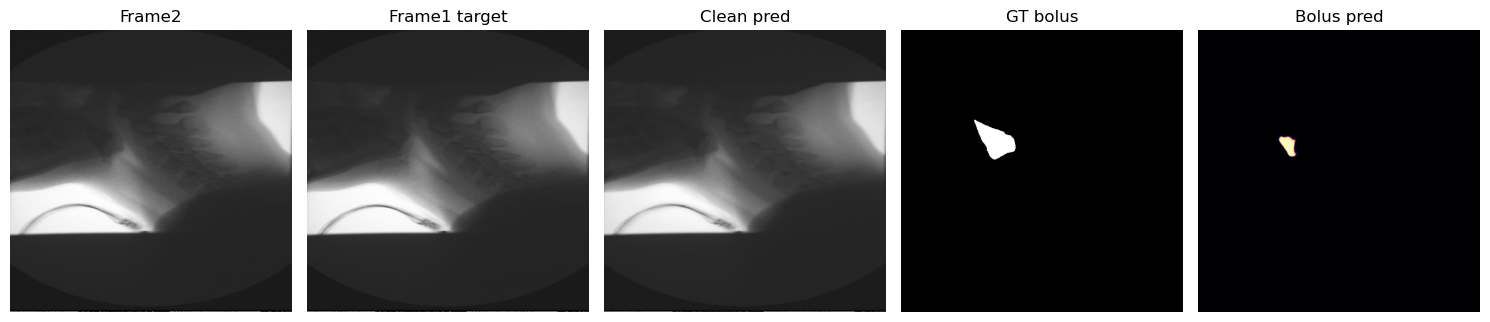

In [18]:
# Visualization
clean_unet.eval(); bolus_unet.eval()
target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']
with torch.no_grad():
    frame2, frame1, mask1 = next(iter(target_loader))
    clean_pred = clean_unet(frame2.to(device)).cpu()
    bolus_pred = bolus_unet(torch.cat([frame2.to(device), clean_pred.to(device)], dim=1)).cpu()

idx = 0
fig, axes = plt.subplots(1, 5, figsize=(15,4))
axes[0].imshow(frame2[idx,0], cmap='gray'); axes[0].set_title('Frame2')
axes[1].imshow(frame1[idx,0], cmap='gray'); axes[1].set_title('Frame1 target')
axes[2].imshow(clean_pred[idx,0], cmap='gray', vmin=0, vmax=1); axes[2].set_title('Clean pred')
axes[3].imshow(mask1[idx,0], cmap='gray'); axes[3].set_title('GT bolus')
axes[4].imshow(bolus_pred[idx,0], cmap='magma', vmin=0, vmax=1); axes[4].set_title('Bolus pred')
for ax in axes: ax.axis('off')
plt.tight_layout(); plt.show()
